# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


### Explore

In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


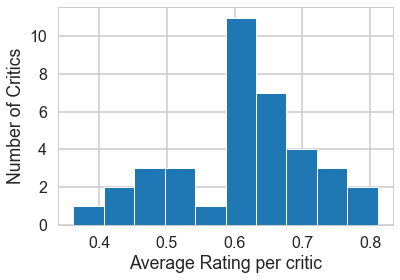

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

The distribution has a surprising jump at 0.6, suggesting that many critics may be hesitant to give a 5-or-below rating.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [6]:
critics[:5]

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [7]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y

X, y = make_xy(critics)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1)

In [9]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
from sklearn.metrics import accuracy_score

y_pred = mnb.predict(x_train)
accuracy_score(y_train, y_pred)
mnb.score(x_train, y_train)

0.91638103399028847

In [11]:
y_pred = mnb.predict(x_test)
accuracy_score(y_test, y_pred)
mnb.score(x_test, y_test)

0.78869621066152862

Well, it's better at predicting the training data than it is the test data, which makes sense, but I believe this indicates overfitting. Overall, though, 78% accuracy in an off-the-shelf, no-tuning model seems surprisingly good.

### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

In [12]:
doc_freq = np.zeros(22417)
for x in list(x_train):
    doc_freq = doc_freq + x.toarray()[0]
doc_freq.sort()

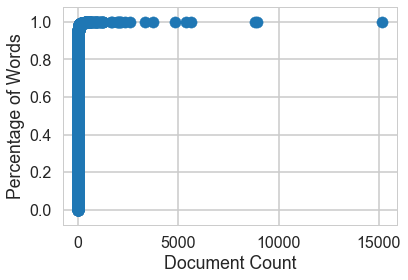

In [13]:
x = doc_freq
y = np.linspace(0,1,len(x))

plt.scatter(x, y)
plt.xlabel('Document Count')
plt.ylabel('Percentage of Words')
None

Wow, okay, some words are massive outliers. A more interesting CDF would limit the document frequency...

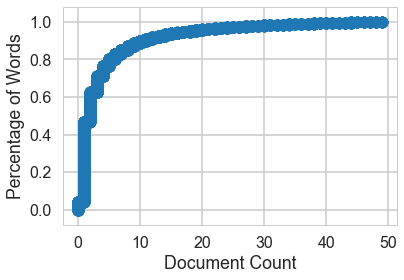

In [14]:
x = doc_freq[doc_freq < 50]
y = np.linspace(0,1,len(x))

plt.scatter(x, y)
plt.xlabel('Document Count')
plt.ylabel('Percentage of Words')
None

So it looks like you can cull a large share of the features by setting min_df equal to, say, three, and max_df to thirty.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [15]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold, random_state=42).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [16]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [17]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

log_likelihood calculates the predicted log probability, for each document, that it belongs to class "rotten" and class "fresh", and returns the sum of the true positives of those probabilities. Because the log of a float between zero and one is going to be, at most, zero, these figures are negative, with the least-negative numbers being best. We are trying to optimize for probabilities assessed to true positives.

I really do not understand what alpha is doing. 

In the following exercise, I originally assumed best_min_df = 3, but the instructions in the comments violate the instructions in the exercise, so I decided to try a range of min_df values and found that alpha=1, min_df=4 is actually slightly better than my original finding of alpha=1, min_df=3. I then reverted back to defining best_min_df as an int, instead of an array, due to the demands of the next exercise.

It also says to find the best classifier, not sure what that means, so I'm letting it go.

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
best_min_df = 4

#Find the best value for alpha and min_df, and the best classifier
best_alpha = 1
maxscore=-np.inf
for alpha in alphas:
    clf = MultinomialNB(alpha=alpha)
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    print(f'for alpha={alpha}, min_df={best_min_df}, score is', cv_score(clf, Xtrainthis, ytrainthis, log_likelihood))

for alpha=0.1, min_df=4, score is -944.427967006
for alpha=1, min_df=4, score is -599.696224608
for alpha=5, min_df=4, score is -727.752410844
for alpha=10, min_df=4, score is -932.703568188
for alpha=50, min_df=4, score is -1156.56631814


In [19]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

Holy crap it's worse after removing the stopwords, I give up. I guess log_likelihood is testing something other than accuracy.

In [20]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.914543
Accuracy on test data:     0.747154


In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2736 1481]
 [1273 5402]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [22]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
             delight 0.95
             kubrick 0.94
             triumph 0.93
              thanks 0.93
              easily 0.93
           audacious 0.93
             stylish 0.93
         brilliantly 0.93
        nevertheless 0.93
             british 0.92
Bad words	     P(fresh | word)
          equivalent 0.11
             witless 0.11
             quickly 0.11
               bland 0.10
              stupid 0.09
       unfortunately 0.09
      disappointment 0.09
               worst 0.08
          uninspired 0.07
                lame 0.06


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

Well, it's basically a fictional corpus of one-word documents, with a document for each word appearing in the corpus, and then we are predicting on those documents. The probability represents the conditional probability that this document is in the "fresh" class given the word it contains. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [23]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
A lightweight romance for the senior crowd, Last Chance Harvey does nothing in particular, but it does it fairly well thanks to stars Dustin Hoffman and Emma Thompson.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

This pacifist spirit of brotherhood echoes the heroics in Princess Mononoke and other anime titles, but the artistic gap between the Miyazaki masterpiece and this project is huge.

Handsome and well-acted, the film's ultimate success depends on the heat between Ryder and Day-Lewis, and it simply isn't there. The attraction is fatal alright, but it certainly doesn't seem mutual.

If it's to be experienced at all, Return to Paradise is best seen as a lively piece of pulp, not a profound exploration of the vagaries of the human soul.

Mis-p

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [24]:
X = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])

probs = clf.predict_proba(X)
probs[0][1]

0.99642329520572159

Very, very high freshness. That makes sense, given the bag of words not responding to the "not" in the sentence.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

In [26]:
# first, a baseline - our best solution from earlier

vectorizer = CountVectorizer(min_df=4)

X, y = make_xy(critics, vectorizer)
X = X[mask]
y = y[mask]

clf = MultinomialNB(alpha=1)
cv_score(clf, X, y, log_likelihood)

-599.69622460845153

In [27]:
# Exercise 1
# now, let's n_gram for 1, 2, and 3 lengths 

vectorizer = CountVectorizer(min_df=4, ngram_range=(1,3))

X, y = make_xy(critics, vectorizer)
X = X[mask]
y = y[mask]

clf = MultinomialNB(alpha=1)
cv_score(clf, X, y, log_likelihood)

-810.76406217500119

Welp, that didn't go anywhere.

In [28]:
# Exercise 2
# trying Random Forests

from sklearn.ensemble import RandomForestClassifier

def rfc_log_likelihood(clf, x, y):
    prob = np.log(clf.predict_proba(x) + 0.00001)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

vectorizer = CountVectorizer(min_df=4)

X, y = make_xy(critics, vectorizer)
X = X[mask]
y = y[mask]

clf = RandomForestClassifier(min_samples_split=5, random_state=42)
cv_score(clf, X, y, rfc_log_likelihood)

-609.75799230291409

Okay, so Random Forest tends to return zero-probabilities, which is stupid because it has a predict_log_proba() method, which obviously runs into serious issues at zero. So I redefined log_likelihood() to use the predict_proba() method with a small adjustment to avoid zeroes.

Not sure if this counts, but it actually did pretty well.

In [29]:
# Exercise 3
# Okay so the data provided includes no supplemental features so I'm not sure how to do that
# other than gathering data myself but that seems above and beyond what these usually ask for,
# so I think this is a mistake?

In [30]:
# Exercise 4
# LDA - testing different n_topics values

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import KFold

def lda_cv_score(clf, X, y, scorefunc):
    nfold = 5
    topic_no = [5, 10, 100, 500]
    for number in topic_no:
        result = 0.
        lda = LatentDirichletAllocation(n_topics=number, learning_method='batch', random_state=42, n_jobs=-1)
        X = lda.fit_transform(X)
        for train, test in KFold(nfold, random_state=42).split(X): # split data into train/test groups, 5 times
            clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
            result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
        average = result / nfold # average
        print(f'For LDA n_topics={number}, log_likelihood={average}')

vectorizer = CountVectorizer(min_df=4)

X, y = make_xy(critics, vectorizer)
X = X[mask]
y = y[mask]

clf = MultinomialNB(alpha=1)
lda_cv_score(clf, X, y, log_likelihood)

For LDA n_topics=5, log_likelihood=-628.394652219096
For LDA n_topics=10, log_likelihood=-629.30241332516
For LDA n_topics=100, log_likelihood=-629.0143129485501
For LDA n_topics=500, log_likelihood=-630.2125784314039


In [31]:
# Exercise 4
# LDA - Let's mess around with doc_topic_prior

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import KFold

def lda_cv_score(clf, X, y, scorefunc):
    nfold = 5
    topic_prior = [0.001, 0.01, 0.1, 0.4]
    for prior in topic_prior:
        result = 0.
        lda = LatentDirichletAllocation(n_topics=10, learning_method='batch', random_state=42, n_jobs=-1,
                                       doc_topic_prior=prior)
        X = lda.fit_transform(X)
        for train, test in KFold(nfold, random_state=42).split(X): # split data into train/test groups, 5 times
            clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
            result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
        average = result / nfold # average
        print(f'For LDA doc_topic_prior={prior}, log_likelihood={average}')

vectorizer = CountVectorizer(min_df=4)

X, y = make_xy(critics, vectorizer)
X = X[mask]
y = y[mask]

clf = MultinomialNB(alpha=1)
lda_cv_score(clf, X, y, log_likelihood)

For LDA doc_topic_prior=0.001, log_likelihood=-628.6718541078914
For LDA doc_topic_prior=0.01, log_likelihood=-628.6761287101988
For LDA doc_topic_prior=0.1, log_likelihood=-629.3602614309615
For LDA doc_topic_prior=0.4, log_likelihood=-630.1776658231383


In [32]:
# Exercise 4
# LDA - now I'll mess around with topic_word_prior

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import KFold

def lda_cv_score(clf, X, y, scorefunc):
    nfold = 5
    topic_word_prior = [0.001, 0.01, 0.1, 0.4]
    for prior in topic_word_prior:
        result = 0.
        lda = LatentDirichletAllocation(n_topics=10, learning_method='batch', random_state=42, n_jobs=-1,
                                       topic_word_prior=prior)
        X = lda.fit_transform(X)
        for train, test in KFold(nfold, random_state=42).split(X): # split data into train/test groups, 5 times
            clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
            result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
        average = result / nfold # average
        print(f'For LDA topic_word_prior={prior}, log_likelihood={average}')

vectorizer = CountVectorizer(min_df=4)

X, y = make_xy(critics, vectorizer)
X = X[mask]
y = y[mask]

clf = MultinomialNB(alpha=1)
lda_cv_score(clf, X, y, log_likelihood)

For LDA topic_word_prior=0.001, log_likelihood=-627.8039153657138
For LDA topic_word_prior=0.01, log_likelihood=-629.1228620720276
For LDA topic_word_prior=0.1, log_likelihood=-629.4148906216599
For LDA topic_word_prior=0.4, log_likelihood=-629.4326426786076


This was my first time applying LDA and it really increased my confidence with scikit - I would have never known where to even start before Springboard, but now I feel confident enough to take something I only vaguely understand, hack around with it, and produce some results. That's the grounding I really wanted.

I tested this with a variety of n_topics values, assuming that higher numbers of topics would produce better results. I found almost no difference between 10, 100, 500, 1000, and 3000, other than the incredibly long runtimes at those higher values. Values converged on -623.615, with slightly better performance on lower topic levels. Can the entirety of this corpus be reduced to five topics with only minimal loss in predictive power? That's incredible. What does that imply about this corpus? I genuinely have no idea.

I have no idea, conceptually, what doc_topic_prior does, but it's near the top of the list and it doesn't claim to be for online processing online so I tried it out. Same with word_topic_prior. No difference in either.

All the other attributes of sklearn's LDA seemed irrelevant to this batch process.

In [33]:
# Exercise 5
# Applying a tf-idf vectorizer instead of a count vectorizer

def log_likelihood(clf, x, y):
    prob = np.log(clf.predict_proba(x) + 0.00001)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=4)

X, y = make_xy(critics, vectorizer)
X = X[mask]
y = y[mask]

clf = MultinomialNB(alpha=1)
cv_score(clf, X, y, log_likelihood)

-536.04990572101906

My full faith in tf-idf has been vindicated once again.